# Introduction

This notebook will perform experiments and explore the sklearn implementations of algorithms that assume a linear relation between the features and the target variable. After extensively exploring the performance of these algorithm for different data configurations (with varying number of features, number of observations, type of targets, type of processing), we will test the most meaningful findings with the house price competition data, trying to find our learning again in those settings.

For a broad introduction on linear models, please refer to https://en.wikipedia.org/wiki/Linear_regression or to any good book of statistics. Here a quick summary

The main assumption of such models is that the target `y` is related with the explanatory variables as $$y = \alpha + \beta_1 x_1 + \dots + \beta_n x_n,$$
and our goal is to estimate the values of $\alpha$ and $\beta_i$.

The other assumptions for most of the models are
* Constant variance (homoscedasticity) of the errors, independently of the value of the variables. This assumption simplifies the computation.
* Independence of errors of the predicted target variable, which should not have correlation
* No perfect multicollinearity between the variables
* The predictors are assumed to be error free

In [1]:
import pandas as pd
import numpy as np

import source.hyperplots as hyp
import source.explore as exp
from source.report import plot_predictions, make_results, store_results
from source.utility import cv_score, grid_search
import source.transf_univ as df_p

from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge, Perceptron

%matplotlib inline
pd.set_option('max_columns', 500)

In [2]:
numeric_pipe = Pipeline([('fs', df_p.feat_sel('numeric')),
                         ('imputer', df_p.df_imputer(strategy='median'))])


cat_pipe = Pipeline([('fs', df_p.feat_sel('category')),
                     ('imputer', df_p.df_imputer(strategy='most_frequent')), 
                     ('dummies', df_p.dummify())])

processing_pipe = df_p.FeatureUnion_df(transformer_list=[('cat_pipe', cat_pipe),
                                                    ('num_pipe', numeric_pipe)])

model = Pipeline([('processing', processing_pipe),
                  ('scl', df_p.df_scaler()), 
                  ('linear', LinearRegression())])

kfolds = KFold(10, shuffle=True, random_state=541)

The simplest LinearRegression can be implemented as above, we can quickly test it via the functions we developed in Notebook 02.

For example, we see that for a target generated by a linear function of the features we get a very good model

In [3]:
df = pd.read_csv('data/simulated/clean.csv')

df_train = df[[col for col in df.columns if not col.startswith('tar_') and 'unc' in col]].copy()

target = df['tar_lin_unc']

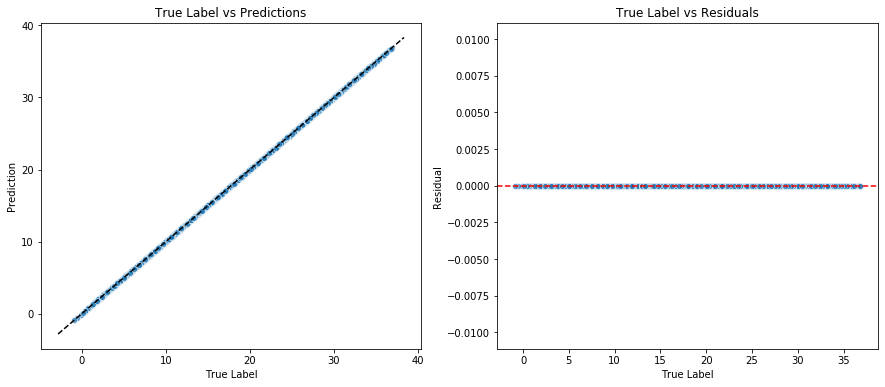

In [4]:
oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

However, we see that not necessarily we estimate the coefficients correctly

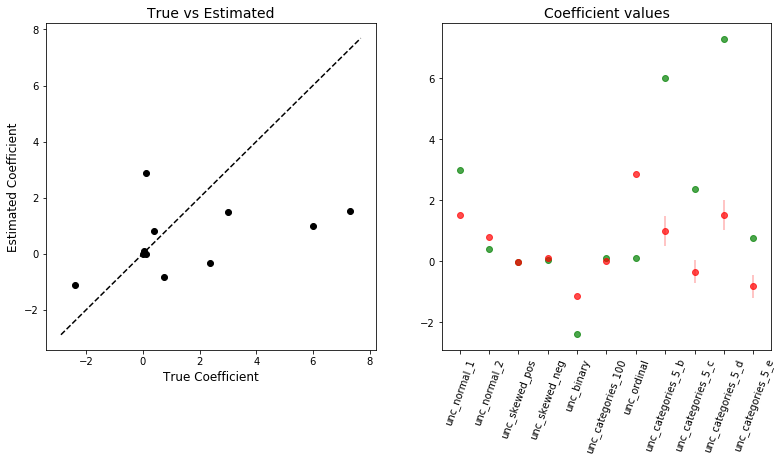

In [5]:
hyp.plot_coefficients('tar_lin_unc', coefs_est)

In [6]:
res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_lin_unc', variables='unc', instances=100000, verbose=True)

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


On the other hand, we see that if the target is generated non-linearly, the model performs poorly

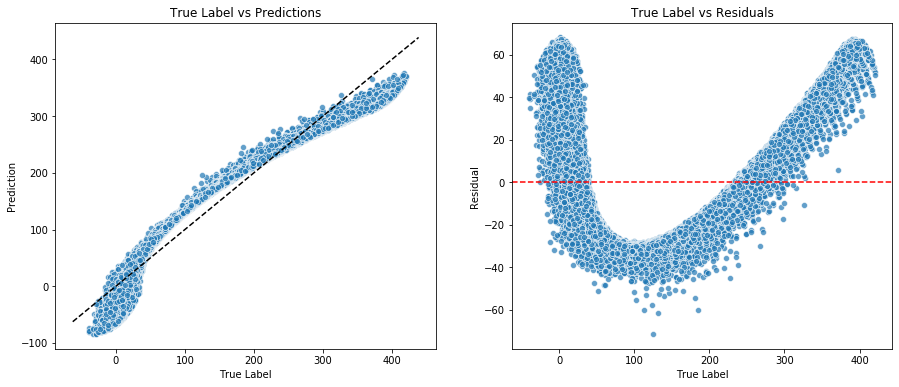

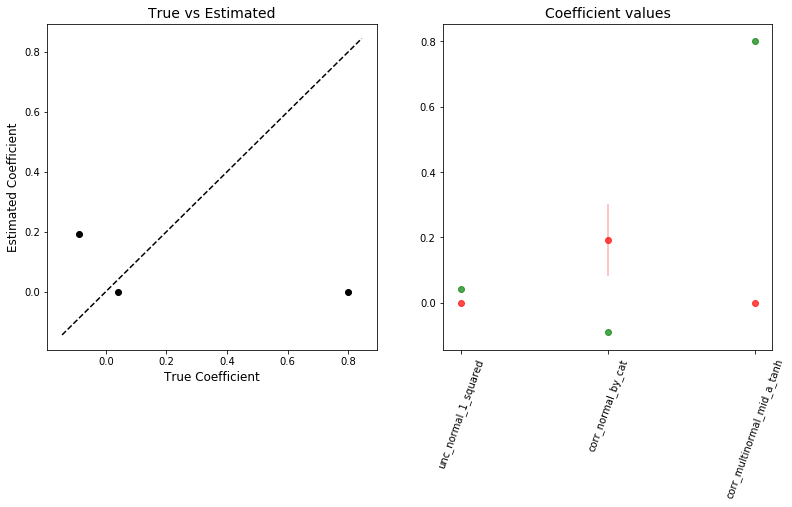

MAE: 		 25.16247
MSE: 		 856.86992
Max Error: 	 71.33318
Expl Variance: 	 0.93908


In [7]:
df_train = df[[col for col in df.columns if not col.startswith('tar_')]].copy()

target = df['tar_nonlin_3']

oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

hyp.plot_coefficients('tar_nonlin_3', coefs_est)

res = make_results(label=target, prediction=oof, model='LinearRegression', 
                   parameters={'standard'}, 
                   target_name='tar_nonlin_3', variables='All', instances=100000, verbose=True)

Please keep in mind that the plot of the coefficients in plotting a point at 0 if the real coefficient can't be found in the estimated one (for example if it is the coefficient of a variable that does not exists in our data)

For each model, we will have a look at these metrics and store the results when needed. We will iterate on different data and model configurations with the goal of understanding how all these moving parts are playing with one another.

# Experiments

## LinearRegression

We have seen already that if the target is linearly generated, we can perfectly fit the data (please keep in mind that all the predictions and the scores are referring to the performance on an holdout set with a 10 fold CV scheme). The model has very few hyperparameters ([see the sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)) and we thus investigate the performance of the model when we change the input data.

In [8]:
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Linear functions, noise, correlation

In this section, we see how `LinearRegression` can fit data and predict a target variable generated by a linear relation.

First, we use a dataset of 100000 observations, 10 variables, all of which were used to generate the target without noise.

In [17]:
def experiment_lr(data_name, kfolds, store=False, sample=False):
    df = pd.read_csv(data_name)
    if sample:
        df = df.sample(sample)
    
    coefs_name = data_name.split('.csv')[0] + '__coefficients.csv'
    target_name = data_name.split('/')[2].split('.csv')[0]

    target = df['target']

    df_train = df.drop('target', axis=1)

    model = Pipeline([('processing', numeric_pipe),
                      ('scl', df_p.df_scaler()), 
                      ('linear', LinearRegression())])

    oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

    plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

    hyp.plot_coefficients('tar_nonlin_3', coefs_est, 
                          coefs_real=coefs_name)
    
    if store:
        store_results('data/03_linear_models.csv', 
                      label=target, prediction=oof, model='LinearRegression', 
                      parameters={'Irrelavant'}, 
                      target_name=target_name, variables='All', instances=df_train.shape[0], verbose=True)
    else:
        res = make_results(label=target, prediction=oof, model='LinearRegression', 
                           parameters={'Irrelavant'}, 
                           target_name=target_name, variables='All', instances=df_train.shape[0], verbose=True)
    

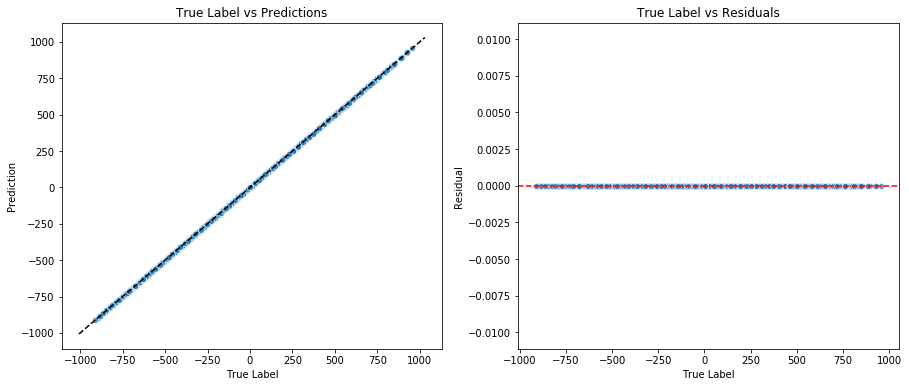

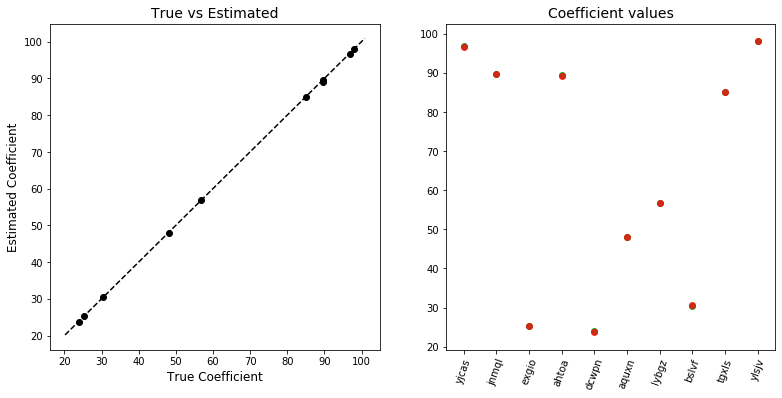

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [10]:
experiment_lr('data/simulated/10_feat_10_inf_nonoise.csv', kfolds, store=True)

However, already using a target generated with some **noise** we notice a significant drop in performance

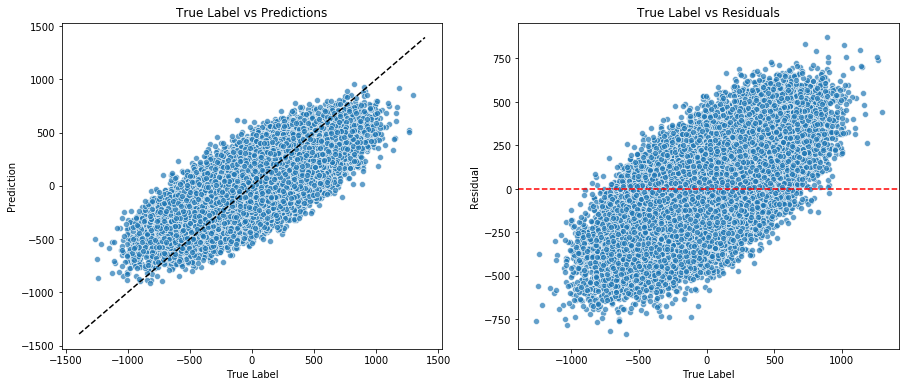

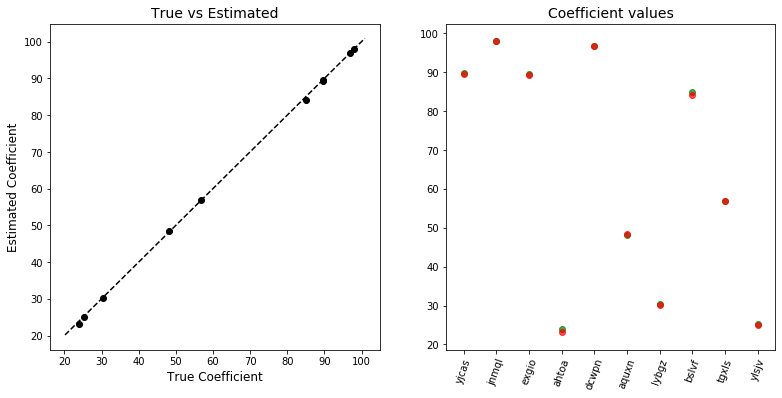

MAE: 		 159.15957
MSE: 		 39903.46378
Max Error: 	 870.78547
Expl Variance: 	 0.55337


In [11]:
experiment_lr('data/simulated/10_feat_10_inf_noise.csv', kfolds, store=True)

Still a reasonably good estimation of the coefficients, something that deteriorates if we have more coefficients (for example, 65 informative features over 100 available)

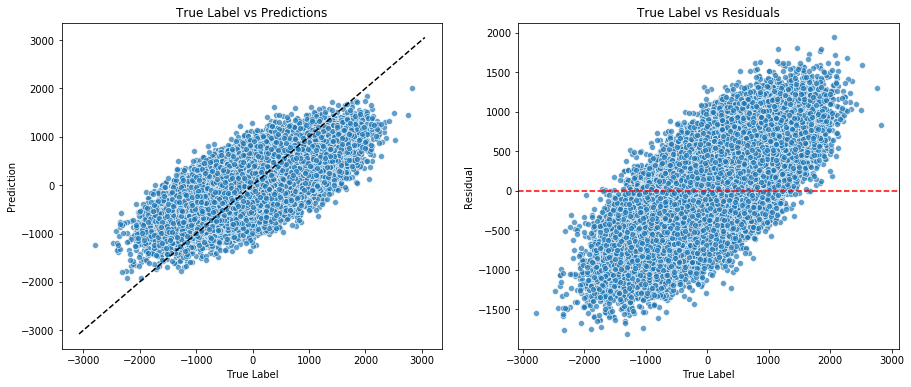

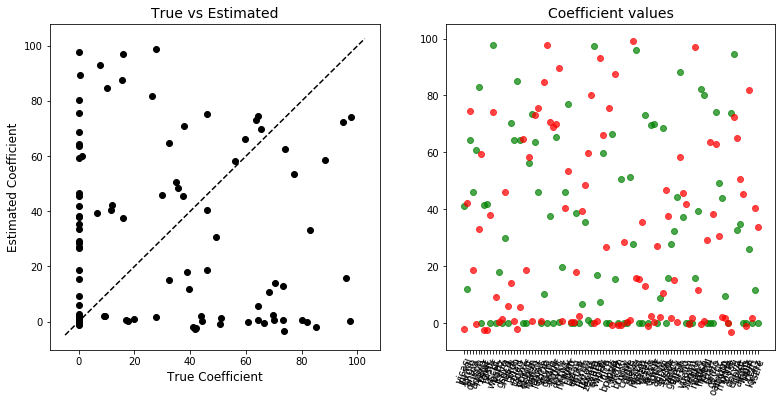

MAE: 		 359.51792
MSE: 		 202633.44246
Max Error: 	 1939.61267
Expl Variance: 	 0.48907


In [12]:
experiment_lr('data/simulated/100_feat_65_inf_noise.csv', kfolds, store=True)

Or that we completely lose if we introduce correlation among the features

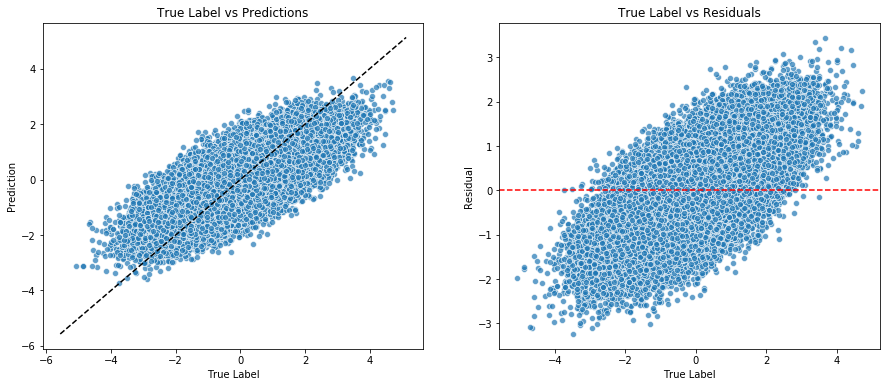

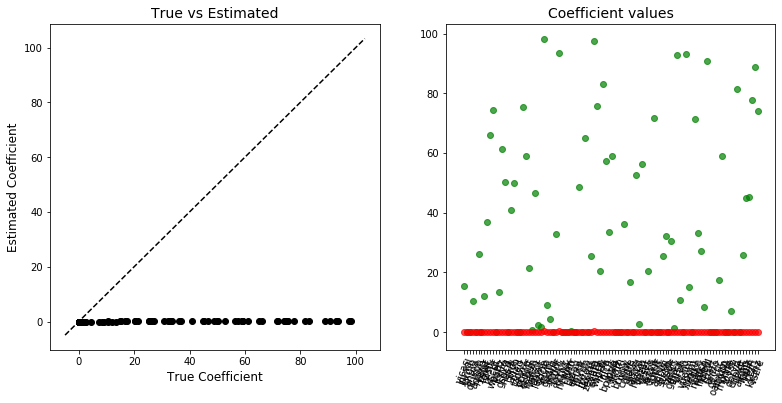

MAE: 		 0.63864
MSE: 		 0.63961
Max Error: 	 3.43738
Expl Variance: 	 0.53145


In [13]:
experiment_lr('data/simulated/100_feat_65_inf_noise_rank.csv', kfolds, store=True)

### Number of instances

If we vary the number of features, we notice interesting patterns. For example, for how much the model is (reasonably) not able to pick up a signal if there is noise, it would get a very similar result by using much fewer training instances and, by using them all, it learns the underlying relation at the best of its possibilities (as we have seen from the perfectly estimated coefficients)

In [14]:
def lr_learning_curve(data_name):
    df = pd.read_csv(data_name)
    
    title = data_name.split('/')[2].split('.csv')[0]

    target = df['target']

    df_train = df.drop('target', axis=1)

    model = Pipeline([('processing', numeric_pipe),
                      ('scl', df_p.df_scaler()), 
                      ('linear', LinearRegression())])

    hyp.plot_learning_curve(model, title, 
                            df_train, target, scoring='neg_mean_absolute_error')

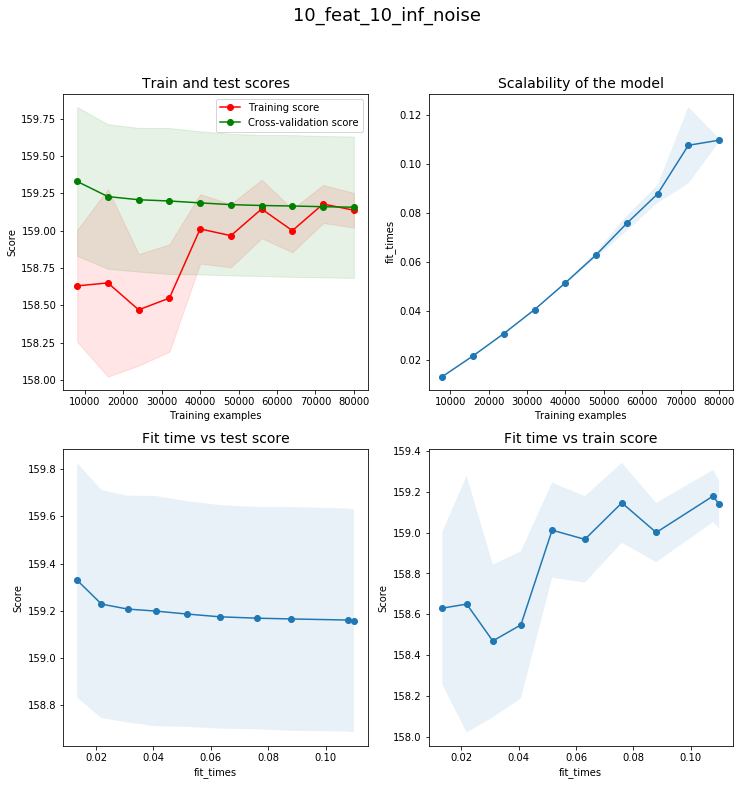

In [15]:
lr_learning_curve('data/simulated/10_feat_10_inf_noise.csv')

As it is expected, if we have more features, the model benefits more from a higher number of training instances.

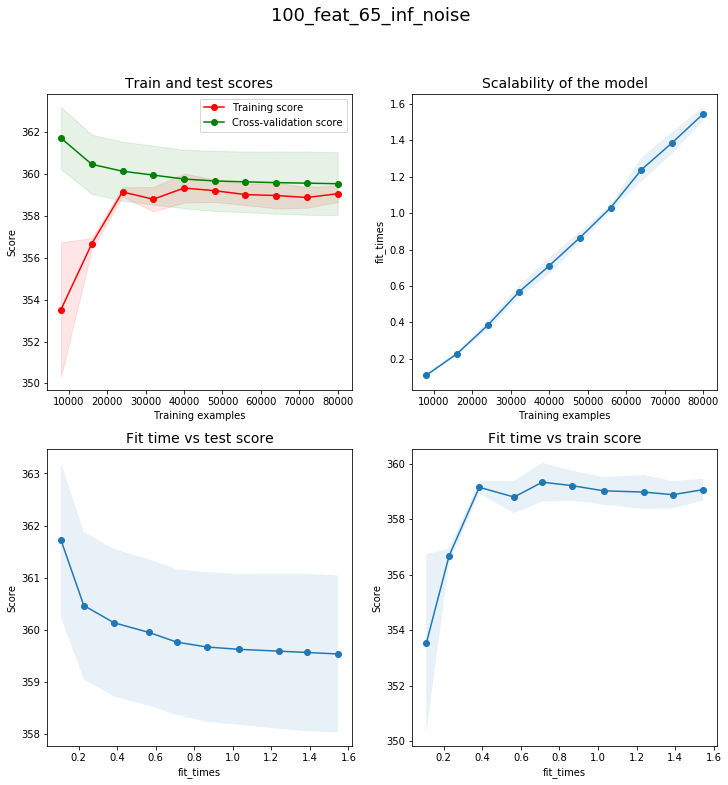

In [16]:
lr_learning_curve('data/simulated/100_feat_65_inf_noise.csv')

We can then look at the results of our experiment if we limit the number of instances to a very low number and notice how the estimate of the coefficients, that was perfect before, deteriorates both in the simple (even though the predictions remain perfect) and noisy cases.

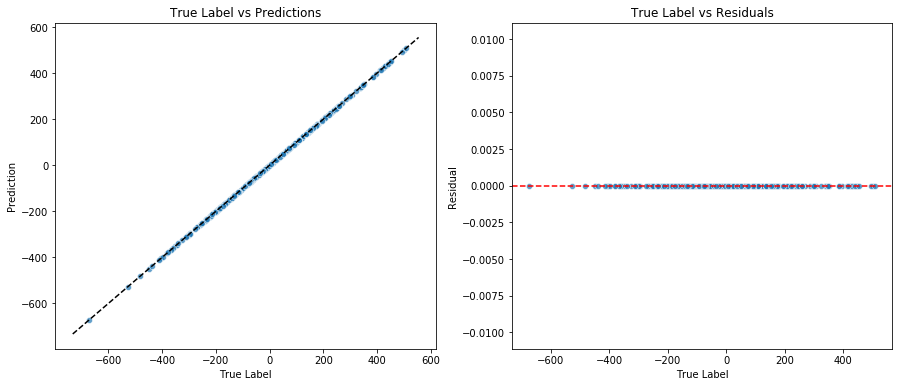

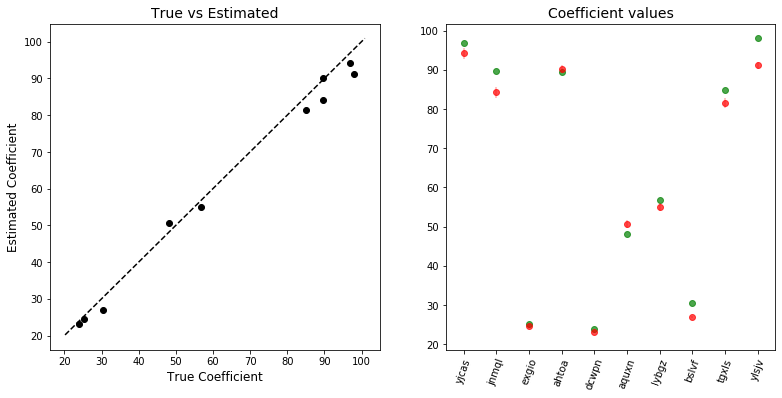

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [26]:
experiment_lr('data/simulated/10_feat_10_inf_nonoise.csv', kfolds, store=True, sample=300)

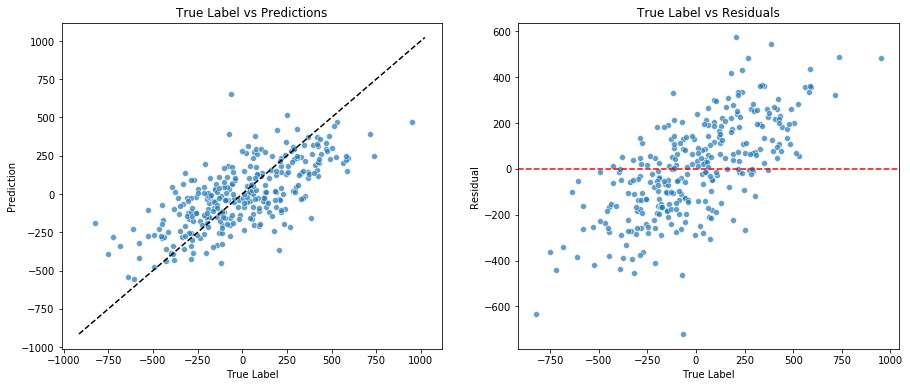

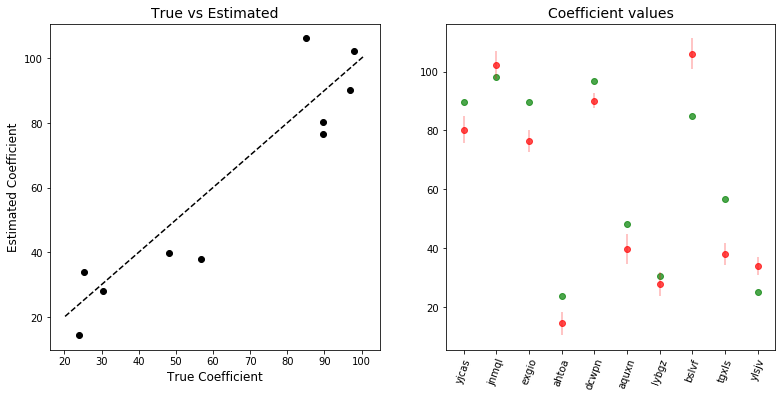

MAE: 		 167.38046
MSE: 		 44097.11816
Max Error: 	 719.76053
Expl Variance: 	 0.48904


In [23]:
experiment_lr('data/simulated/10_feat_10_inf_noise.csv', kfolds, store=True, sample=300)

### Good performance, bad coefficients

We have seen before that we can have a model that perfectly fits the data but estimates poorly the coefficients. Let's see how is this possible.

To do so, let's take dataset without noise where the target was generated by a fraction of the total available features. Even though the prediction is perfect, the model is setting to 0 a lot of coefficients that are not supposed to be 0, and giving non-null value to many other variables. In other words, a linear combination of variables can potentially substitute the effect that another variable is having on the target.

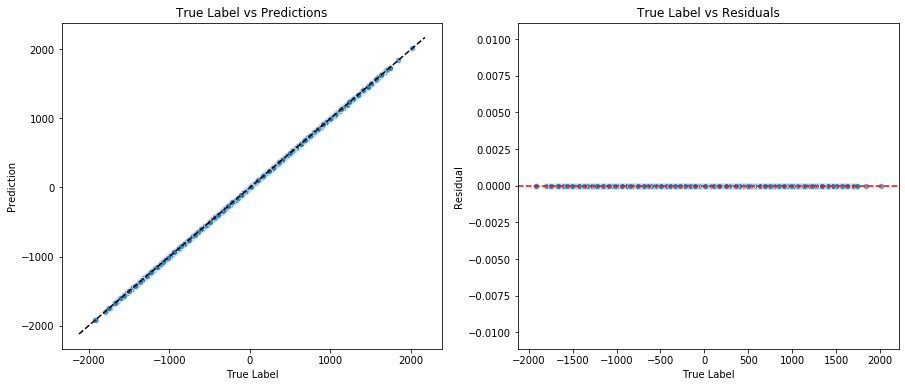

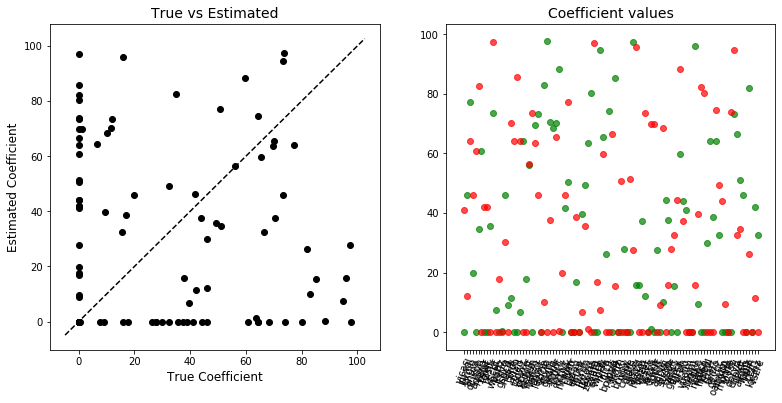

MAE: 		 0.0
MSE: 		 0.0
Max Error: 	 0.0
Expl Variance: 	 1.0


In [27]:
experiment_lr('data/simulated/100_feat_65_inf_nonoise.csv', kfolds, store=True)

Interestingly enough, if we restrict the training variables to the one that were actually used to generate the model, we don't get the same perfect score, showing that the model is already struggling with picking up the signal of each feature.

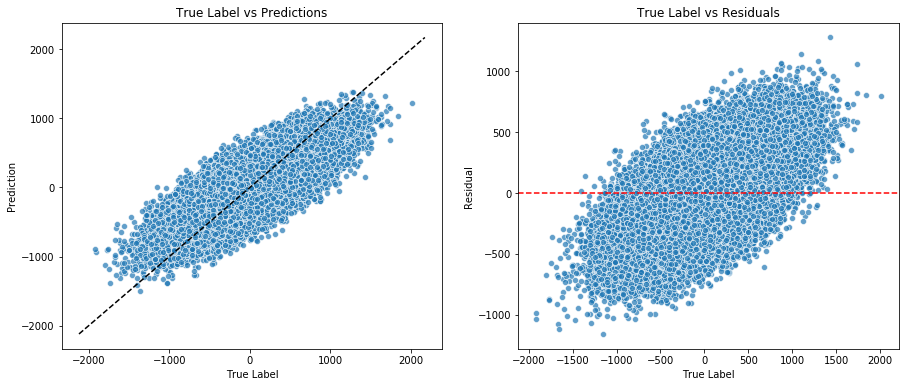

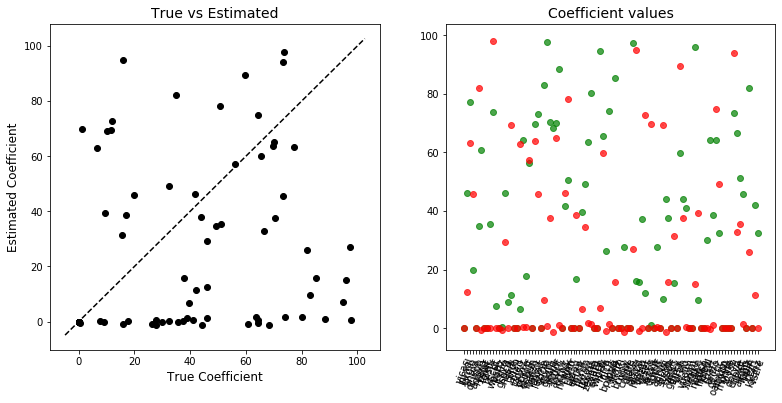

In [28]:
df = pd.read_csv('data/simulated/100_feat_65_inf_nonoise.csv')
real_coefs = pd.read_csv('data/simulated/100_feat_65_inf_nonoise__coefficients.csv')

target = df['target']

df_train = df[[col for col in df.columns if col in real_coefs[real_coefs.coefficient != 0].variable.unique()]]

model = Pipeline([('processing', numeric_pipe),
                  ('scl', df_p.df_scaler()), 
                  ('linear', LinearRegression())])

oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

hyp.plot_coefficients('tar_nonlin_3', coefs_est, 
                      coefs_real='data/simulated/100_feat_65_inf_nonoise__coefficients.csv')

## Ridge

Following [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html), it performs a regression trying to minimize the sum of squared error (as the linear regression above does) with a penalty on the size of the coefficients. Therefore, it tries to minimize the following quantity
$$ ||y - Xw||^2_2 + \alpha  ||w||^2_2 $$, 
where $w$ is the coefficient vector and the parameter $\alpha$ controls the amount of regularization (called $L_2$ as it uses the $L_2$ norm of the coefficient vector). The higher this parameter, the lower will be the variance of the model.

It is a very useful regularization in case of multicollinearity in the input data that tipically lead to very large coefficients. The regularization is putting a penalty on larger coefficients, thus reducing the effect of multicollinearity.

On the contrary of the simple linear regression, we have some hyperparameters to play with

In [19]:
Ridge()

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

* alpha: the regularization and most important hyperparameter to tune. It must be positive. When set to 0, we get the simple Linear regression.
* copy_X: that does not affect the results of the model but, if False, may lead to overwriting the input data
* fit_intercept: whether or not using an intercept term, not relevant for our cases as we, rightfully, always scale and center our data
* max_iter: a parameter that control the maximum number of iterations the solver can take to converge. Very rarely it needs to be increased and, if so, we might need to consider a different approach
* normalize: whether or not normalizing the data and it is ignored if set to False. If True, it uses the StandardScaler we already have in our pipeline
* random_state: relevant only for one of the solver since it is stochastic (the 'sag' solver)
* solver: the type of solver. Almost always leaving to `auto` is a good move as it will pick the best one for the data provided. The coiche will influence the speed and the behavior in particular situations.
* tol: the precision of the solution

## Noise and correlation

We can now repeat the previous experiments and observe how the algorithm is behaving differently even in the simplest case.

In [69]:
def experiment_ridge(data_name, kfolds, store=False, sample=False, **kwargs):
    df = pd.read_csv(data_name)
    if sample:
        df = df.sample(sample)
    
    coefs_name = data_name.split('.csv')[0] + '__coefficients.csv'
    target_name = data_name.split('/')[2].split('.csv')[0]

    target = df['target']

    df_train = df.drop('target', axis=1)

    model = Pipeline([('processing', numeric_pipe),
                      ('scl', df_p.df_scaler()), 
                      ('ridge', Ridge(**kwargs))])

    oof, coefs_est = cv_score(df_train, target, kfolds, model, imp_coef=True)

    plot_predictions(df_train, target, oof, feature=None, hue=None, legend=False, savename=False)

    hyp.plot_coefficients('tar_nonlin_3', coefs_est, 
                          coefs_real=coefs_name)
    
    if len(kwargs.keys()) == 0:
        kwargs = {'alpha': 1}
    
    if store:
        store_results('data/03_linear_models.csv', 
                      label=target, prediction=oof, model='Ridge', 
                      parameters=kwargs, 
                      target_name=target_name, variables='All', instances=df_train.shape[0], verbose=True)
    else:
        res = make_results(label=target, prediction=oof, model='Ridge', 
                           parameters=kwargs, 
                           target_name=target_name, variables='All', instances=df_train.shape[0], verbose=True)

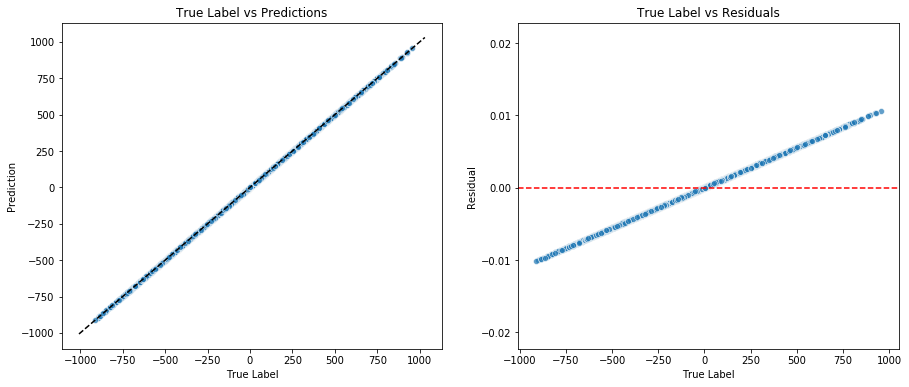

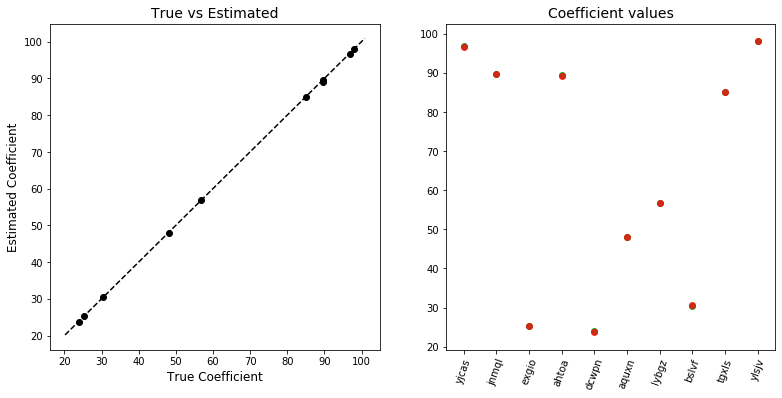

MAE: 		 0.00198
MSE: 		 1e-05
Max Error: 	 0.01069
Expl Variance: 	 1.0


In [70]:
experiment_ridge('data/simulated/10_feat_10_inf_nonoise.csv', kfolds, store=True)

While the coefficients are again estimated perfectly, the residuals show a pattern that suggests that the model is having more and more troubles in predicting larger (in the absolute sense) values of the target variable.

On the other hand, the behavior in presence of noise and/or correlation is the nearly identical

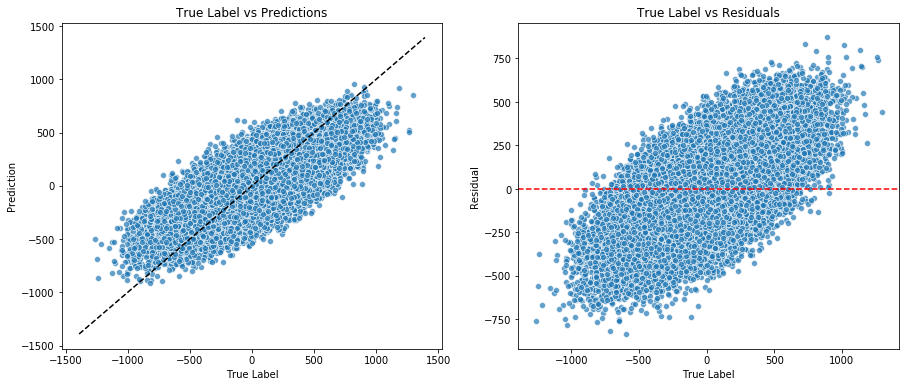

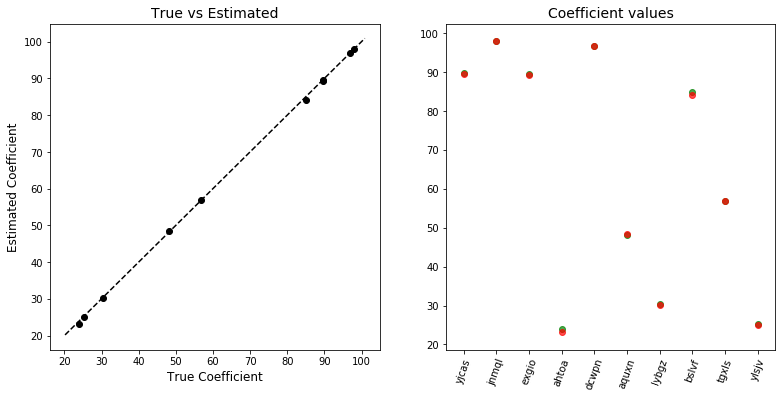

MAE: 		 159.15957
MSE: 		 39903.46366
Max Error: 	 870.78566
Expl Variance: 	 0.55337


In [71]:
experiment_ridge('data/simulated/10_feat_10_inf_noise.csv', kfolds, store=True)

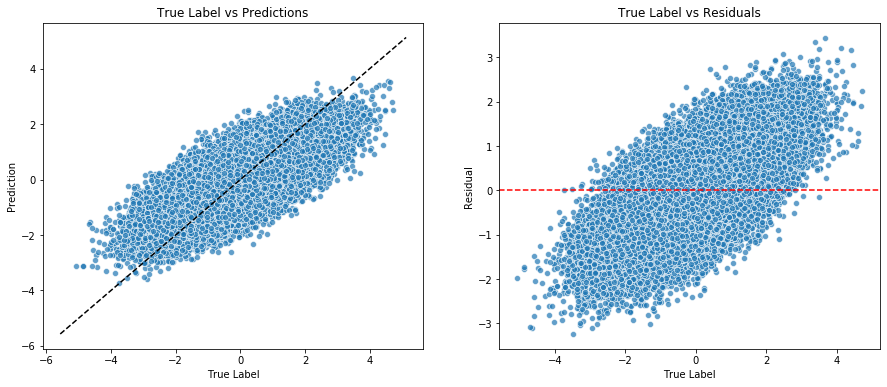

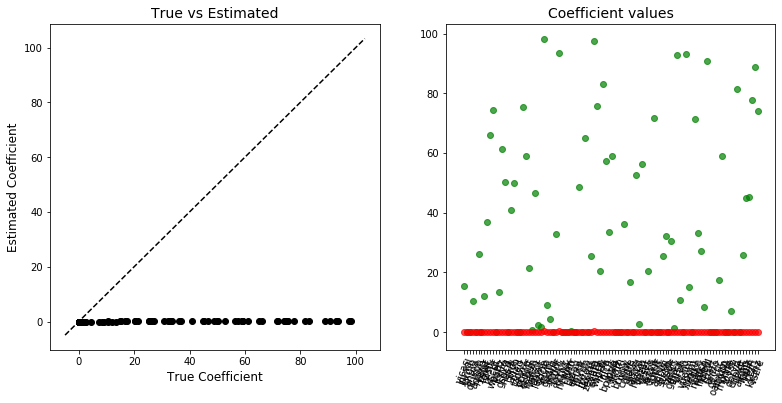

MAE: 		 0.63864
MSE: 		 0.63961
Max Error: 	 3.43738
Expl Variance: 	 0.53145


In [72]:
experiment_ridge('data/simulated/100_feat_65_inf_noise_rank.csv', kfolds, store=True)

## Number of instances

Due to the fact that some of the solvers are faster, the only difference we observe is in the speed. The training time still grows linearly, but with a lower rate of increase.

In [73]:
def ridge_learning_curve(data_name, **kwargs):
    df = pd.read_csv(data_name)
    
    title = data_name.split('/')[2].split('.csv')[0]

    target = df['target']

    df_train = df.drop('target', axis=1)

    model = Pipeline([('processing', numeric_pipe),
                      ('scl', df_p.df_scaler()), 
                      ('ridge', Ridge(**kwargs))])

    hyp.plot_learning_curve(model, title, 
                            df_train, target, scoring='neg_mean_absolute_error')

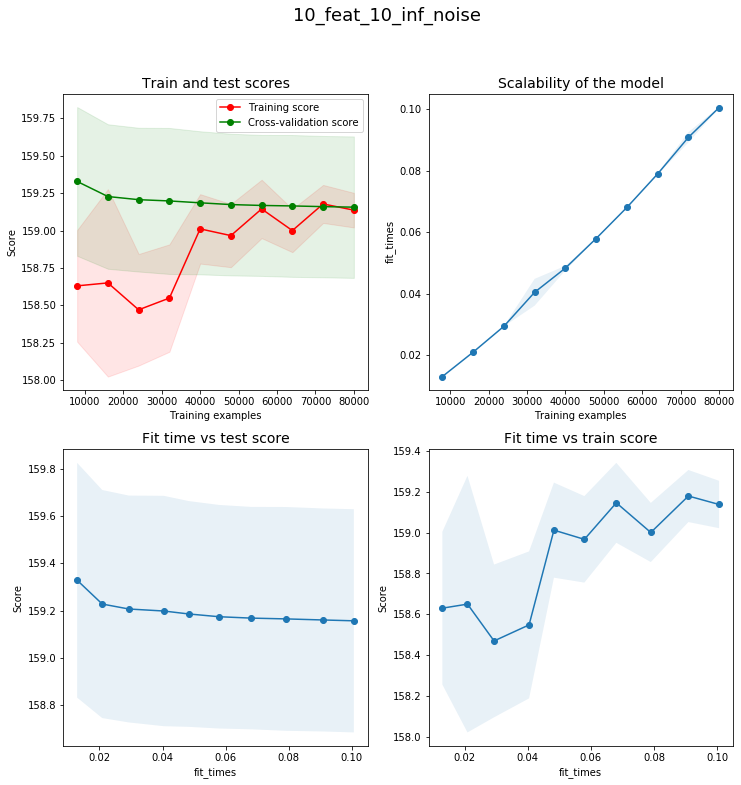

In [75]:
ridge_learning_curve('data/simulated/10_feat_10_inf_noise.csv')

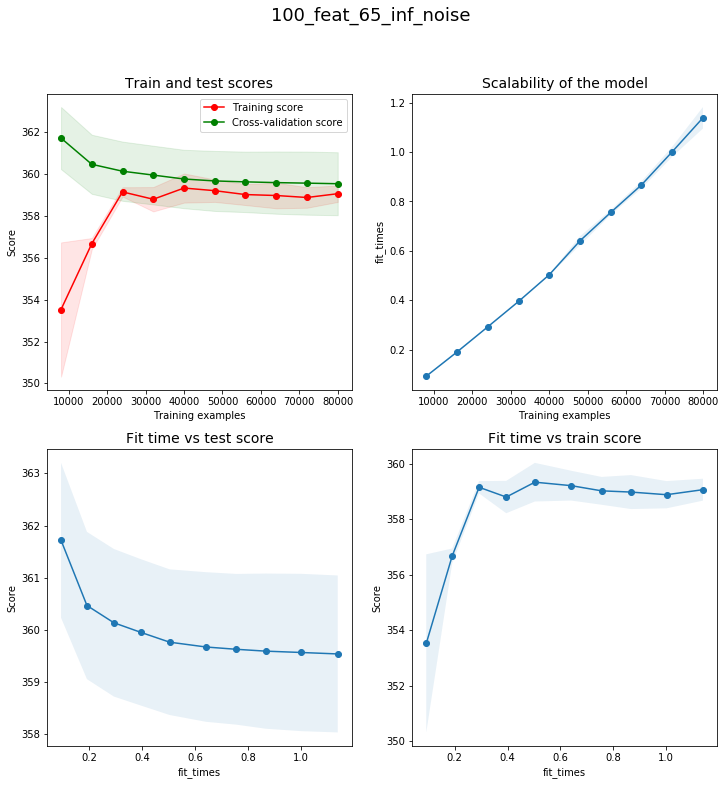

In [76]:
ridge_learning_curve('data/simulated/100_feat_65_inf_noise.csv')

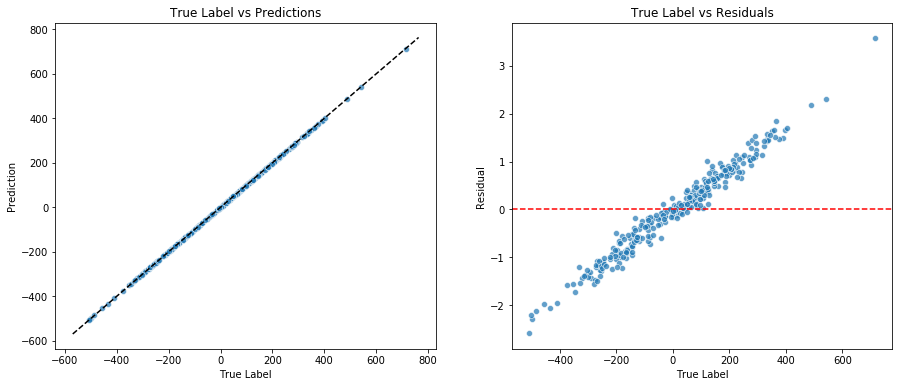

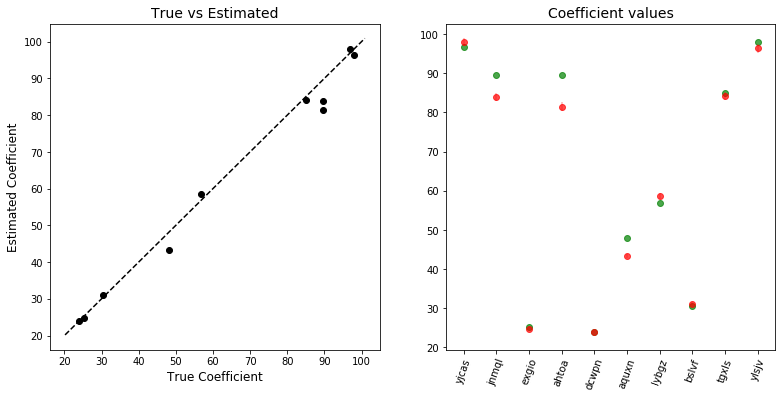

MAE: 		 0.73314
MSE: 		 0.83653
Max Error: 	 3.58481
Expl Variance: 	 0.99998


In [77]:
experiment_ridge('data/simulated/10_feat_10_inf_nonoise.csv', kfolds, store=True, sample=300)

For the first time we notice that the regularized model is performing better than the simple linear regression in presence of noise when the we have a limited number of instances. The better performance is visible in all the metrics and in the coefficients estimates

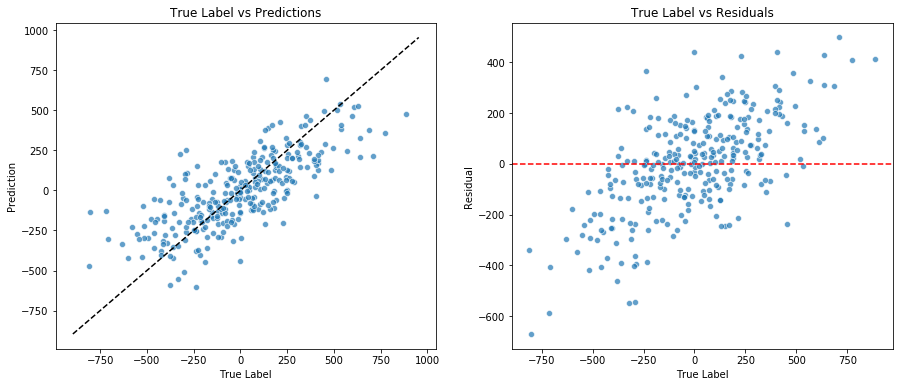

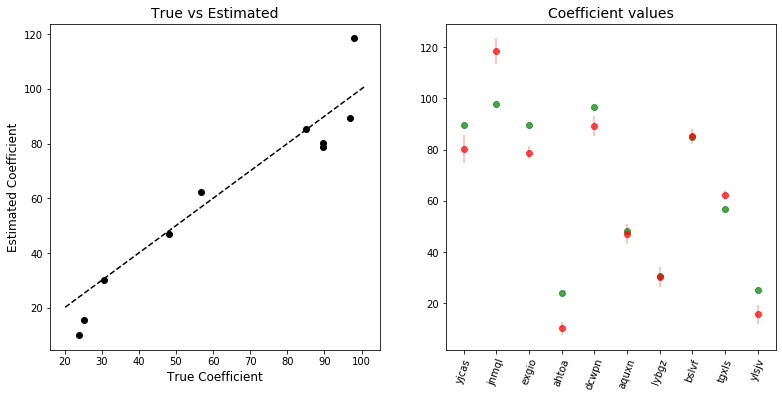

MAE: 		 148.9514
MSE: 		 37147.50309
Max Error: 	 670.0104
Expl Variance: 	 0.57151


In [78]:
experiment_ridge('data/simulated/10_feat_10_inf_noise.csv', kfolds, store=True, sample=300)

## Hyperparameters

All the above experiments were performed using the default hyperparameters, which generally gives a good indication of the model performance to compare results. However, this time we can control more the behavior of the model. This section will do just that.

First, we need to generate the results for different model configurations. We do so by using the custom grid search function imported from the utility module.

We will explore configurations that differ per regularization, precision, and solver type. Due to the need of seeing some pattern, we will use a dataset without noise in order to have errors at an order of magnitude that let us see the variation when the hyperparameter varies. Later, using more complex dataset, we will see more interesting patterns

In [17]:
model = Pipeline([('processing', numeric_pipe),
                  ('scl', df_p.df_scaler()),
                  ('ridge', Ridge(random_state=235))])

param_grid = {'ridge__alpha': list(np.arange(0.05, 10, 0.05)), 
              'ridge__tol': [0.00001, 0.001, 0.1, 1], 
              'ridge__solver': ['svd', 'sparse_cg', 'lsqr', 'saga']}

df = pd.read_csv('data/simulated/100_feat_65_inf_nonoise.csv').sample(300)

target = df['target']

df_train = df.drop('target', axis=1)

res, bp, _ = grid_search(df_train, target, model, param_grid, 'neg_mean_squared_error', kfolds)

print(bp)
res.head()

{'ridge__alpha': 0.05, 'ridge__solver': 'svd', 'ridge__tol': 1e-05}


,param_ridge__alpha,param_ridge__solver,param_ridge__tol,mean_train_score,std_train_score,mean_test_score,std_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,0.05,svd,1e-05,-0.011043,0.000304,-0.027577,0.007153,0.011256,0.000096,0.003264,0.000044
1,0.05,svd,0.1,-0.011043,0.000304,-0.027577,0.007153,0.011105,0.000195,0.003363,0.000088
2,0.05,svd,1,-0.011043,0.000304,-0.027577,0.007153,0.012726,0.004202,0.003358,0.000080
3,0.05,svd,0.001,-0.011043,0.000304,-0.027577,0.007153,0.011033,0.000120,0.003246,0.000061
4,0.05,lsqr,1e-05,-0.011043,0.000304,-0.027593,0.007163,0.009834,0.000501,0.003263,0.000112


First, we see how the choice of the solver is influencing the training time, with `lsqr` and `sparse_cg` being the fastest. On the other hand, different solvers seem to get different scores but it is worth noticing that, by increasing the regularization, this difference becomes less and less relevant.

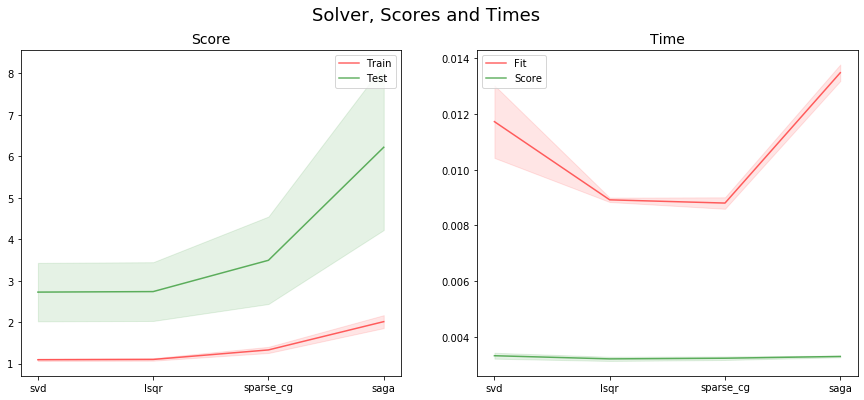

In [21]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 0.5) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

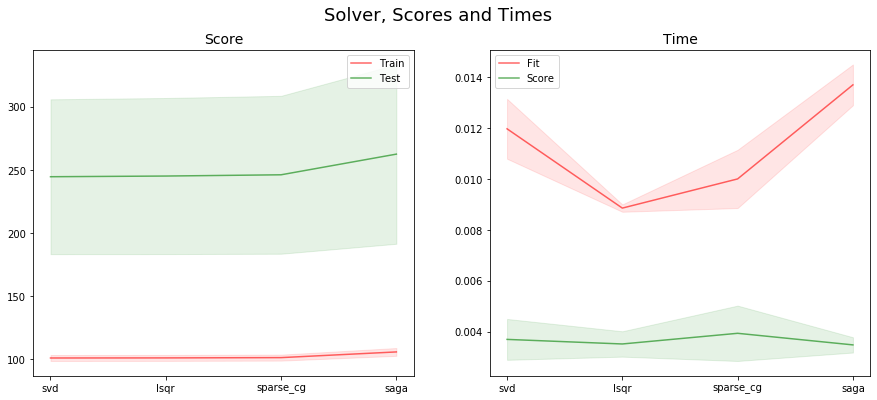

In [24]:
hyp.plot_hyperparameter(res[(res.param_ridge__alpha == 5) & (res.param_ridge__tol==0.001)], 'param_ridge__solver', 'Solver')

This is an artifact of the role of alpha in the model performance, which in this case (a purely linear regression) is getting worse and worse when alpha gets bigger. At the same time, we also notice that this choice does not influence the training time.

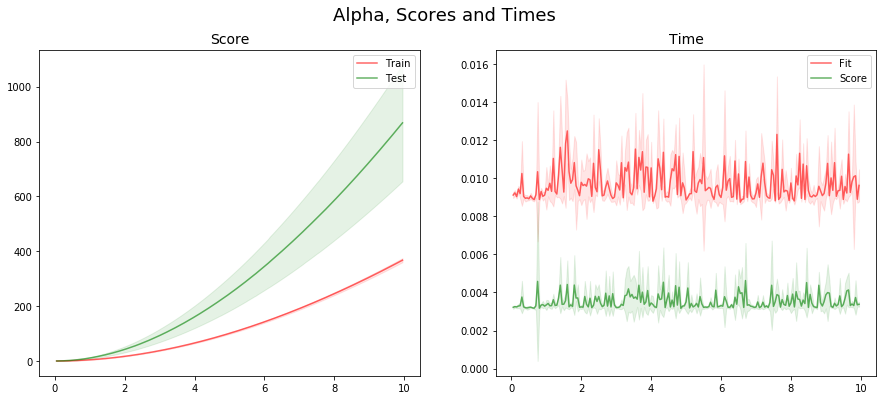

In [22]:
hyp.plot_hyperparameter(res[(res.param_ridge__solver=='lsqr') & (res.param_ridge__tol==0.001)], 'param_ridge__alpha', 'Alpha')

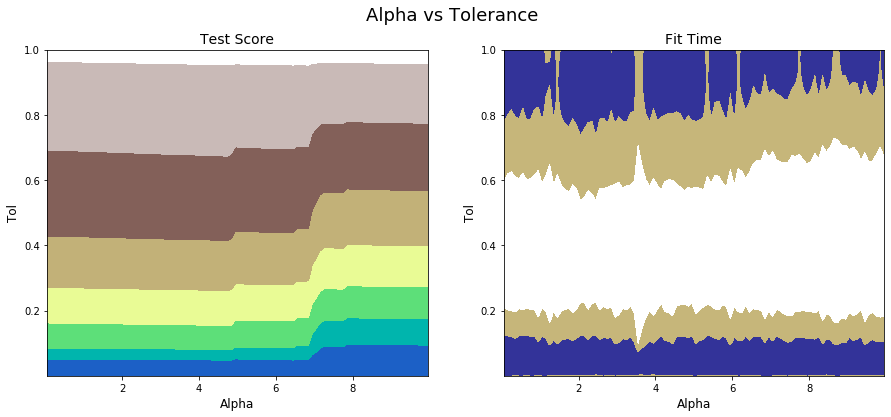

In [26]:
hyp.plot_two_hyperparms(res[(res.param_ridge__solver=='lsqr')], 'param_ridge__alpha', 'param_ridge__tol', 'Alpha vs Tolerance')

# Real application - HousePrice

# Conclusion